In [18]:
import brax
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
#@title A bouncy ball scene
bouncy_ball = brax.Config(dt=0.05, substeps=20, dynamics_mode='pbd')

# ground is a frozen (immovable) infinite plane
ground = bouncy_ball.bodies.add(name='ground')
ground.frozen.all = True
plane = ground.colliders.add().plane
plane.SetInParent()  # for setting an empty oneof

# ball weighs 1kg, has equal rotational inertia along all axes, is 1m long, and
# has an initial rotation of identity (w=1,x=0,y=0,z=0) quaternion
ball = bouncy_ball.bodies.add(name='ball', mass=1)
cap = ball.colliders.add().capsule
cap.radius, cap.length = 0.5, 1

# gravity is -9.8 m/s^2 in z dimension
bouncy_ball.gravity.z = -9.8

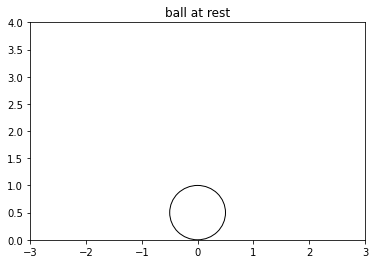

In [19]:
def draw_system(ax, pos, alpha=1):
  for i, p in enumerate(pos):
    ax.add_patch(Circle(xy=(p[0], p[2]), radius=cap.radius, fill=False, color=(0, 0, 0, alpha)))
    if i < len(pos) - 1:
      pn = pos[i + 1]
      ax.add_line(Line2D([p[0], pn[0]], [p[2], pn[2]], color=(1, 0, 0, alpha)))

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

draw_system(ax, [[0, 0, 0.5]])
plt.title('ball at rest')
plt.show()

In [20]:
qp = brax.QP(
    # position of each body in 3d (z is up, right-hand coordinates)
    pos = np.array([[0., 0., 0.],       # ground
                    [0., 0., 3.]]),     # ball is 3m up in the air
    # velocity of each body in 3d
    vel = np.array([[0., 0., 0.],       # ground
                    [0., 0., 0.]]),     # ball
    # rotation about center of body, as a quaternion (w, x, y, z)
    rot = np.array([[1., 0., 0., 0.],   # ground
                    [1., 0., 0., 0.]]), # ball
    # angular velocity about center of body in 3d
    ang = np.array([[0., 0., 0.],       # ground
                    [0., 0., 0.]])      # ball
)

/home/shengjie/anaconda3/envs/rlgpu/lib/python3.7/site-packages/brax/jumpy.py:147: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  return jax.tree_map(lambda x: np.take(x, i, axis=axis, mode='clip'), tree)
/home/shengjie/anaconda3/envs/rlgpu/lib/python3.7/site-packages/brax/jumpy.py:105: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  xs_flat, xs_tree = jax.tree_flatten(xs)
/home/shengjie/anaconda3/envs/rlgpu/lib/python3.7/site-packages/brax/jumpy.py:111: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  carry, y = f(carry, jax.tree_unflatten(xs_tree, xs_slice))
/home/shengjie/anaconda3/envs/rlgpu/lib/python3.7/site-packages/brax/jumpy.py:70: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tre

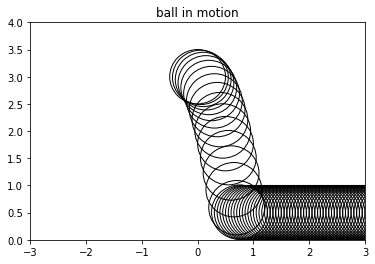

In [21]:
#@title Simulating the bouncy ball config { run: "auto"}
bouncy_ball.elasticity = 0.25 #@param { type:"slider", min: 0, max: 1.0, step:0.05 }
ball_velocity = 1 #@param { type:"slider", min:-5, max:5, step: 0.5 }

sys = brax.System(bouncy_ball)

# provide an initial velocity to the ball
qp.vel[1, 0] = ball_velocity

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(100):
  draw_system(ax, qp.pos[1:], 1.)
  qp, _ = sys.step(qp, [])

plt.title('ball in motion')
plt.show()

In [22]:
#@title A pendulum config for Brax
pendulum = brax.Config(dt=0.01, substeps=20, dynamics_mode='pbd')

# start with a frozen anchor at the root of the pendulum
anchor = pendulum.bodies.add(name='anchor', mass=1.0)
anchor.frozen.all = True

# now add a middle and bottom ball to the pendulum
pendulum.bodies.append(ball)
pendulum.bodies.append(ball)
pendulum.bodies[1].name = 'middle'
pendulum.bodies[2].name = 'bottom'

# connect anchor to middle
joint = pendulum.joints.add(name='joint1', parent='anchor',
                            child='middle', angular_damping=20)
joint.angle_limit.add(min = -180, max = 180)
joint.child_offset.z = 1.5
joint.rotation.z = 90

# connect middle to bottom
pendulum.joints.append(joint)
pendulum.joints[1].name = 'joint2'
pendulum.joints[1].parent = 'middle'
pendulum.joints[1].child = 'bottom'

# gravity is -9.8 m/s^2 in z dimension
pendulum.gravity.z = -9.8

In [ ]:
_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

# rather than building our own qp like last time, we ask brax.System to
# generate a default one for us, which is handy
qp = brax.System(pendulum).default_qp()

draw_system(ax, qp.pos)
plt.title('pendulum at rest')
plt.show()

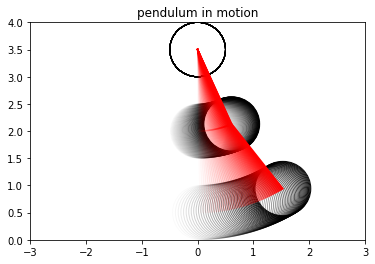

In [23]:
#@title Simulating the pendulum config { run: "auto"}
ball_impulse = 7 #@param { type:"slider", min:-15, max:15, step: 0.5 }

sys = brax.System(pendulum)
qp = sys.default_qp()

# provide an initial velocity to the ball
qp.vel[2, 0] = ball_impulse

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(50):
  draw_system(ax, qp.pos, i / 50.)
  qp, _ = sys.step(qp, [])

plt.title('pendulum in motion')
plt.show()

In [24]:
#@title A single actuator on the pendulum
actuated_pendulum = brax.Config()
actuated_pendulum.CopyFrom(pendulum)

# actuating the joint connecting the anchor and middle
angle = actuated_pendulum.actuators.add(name='actuator', joint='joint1',
                                        strength=100).angle
angle.SetInParent()  # for setting an empty oneof

In [25]:
#@title A single actuator on the pendulum
actuated_pendulum = brax.Config()
actuated_pendulum.CopyFrom(pendulum)

# actuating the joint connecting the anchor and middle
angle = actuated_pendulum.actuators.add(name='actuator', joint='joint1',
                                        strength=100).angle
angle.SetInParent()  # for setting an empty oneof

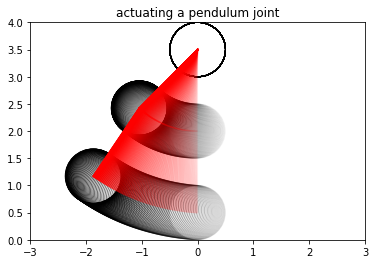

In [26]:
#@title Simulating the actuated pendulum config { run: "auto"}
target_angle = 45 #@param { type:"slider", min:-90, max:90, step: 1 }

sys = brax.System(actuated_pendulum)
qp = sys.default_qp()
act = np.array([target_angle])

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(100):
  draw_system(ax, qp.pos, i / 100.)
  qp, _ = sys.step(qp, act)

plt.title('actuating a pendulum joint')
plt.show()
